In [1]:
import yfinance as yf
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from contextlib import contextmanager
import io
import sys

C:\Users\Yuriy Popryshko\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
symbol_data = pd.read_csv('constituents.csv')


In [3]:
symbols = symbol_data['Symbol']


In [4]:
volatility_data = []


In [5]:
# Redirigir la salida estándar a un archivo

yf.pdr_override()

for symbol in symbols:
    try:
        
        data = yf.download(symbol, start='2023-01-01', end='2023-12-27', progress=False)['Adj Close']
        daily_returns = data.pct_change().dropna()
        volatility = daily_returns.std()
        volatility_data.append({'Symbol': symbol, 'Volatility': volatility})
    except Exception as e:
        print(f"No se pudo obtener datos para {symbol}: {e}")


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-12-27)')


In [6]:
volatility_df = pd.DataFrame(volatility_data)

In [7]:
financial_data = []

for symbol in symbol_data['Symbol']:
    try:
        empresa = yf.Ticker(symbol)
        datos_empresa = empresa.info
        # Añadir el símbolo de la empresa como una columna en los datos financieros
        datos_empresa['Symbol'] = symbol
        financial_data.append(datos_empresa)
    except Exception as e:
        print(f"No se pudieron obtener datos para {symbol}: {e}")

In [8]:
financial_df = pd.DataFrame(financial_data)


In [9]:
merged_data = pd.merge(financial_df, volatility_df, on='Symbol', how='inner')

In [10]:
volatility_df.to_csv('volatilidad.csv',index=False)
financial_df.to_csv('financial.csv',index=False)
merged_data.to_csv('pre_limpieza.csv',index=False)

## Vamos a dividir en bloques las columans para hacer la limpieza y pasar todo a numerico

In [11]:
#SOLO CORRER SI SE CIERRA EL NOTEBOOK Y SE TRABAJA MÁS TARDE
merged_data = pd.read_csv('pre_limpieza.csv')

In [12]:
merged_data.dropna(subset=['Volatility'], inplace=True)

In [13]:
all_columns = merged_data.columns.tolist()

In [14]:
# Tamaño del bloque para dividir las columnas
block_size = 10  # Puedes ajustar este valor según tus necesidades

In [15]:
column_blocks = [all_columns[i:i+block_size] for i in range(0, len(all_columns), block_size)]

In [16]:
for i, block in enumerate(column_blocks):
    print(f"Bloque {i}: Columnas desde '{block[0]}' hasta '{block[-1]}'")

Bloque 0: Columnas desde 'address1' hasta 'industryDisp'
Bloque 1: Columnas desde 'sector' hasta 'shareHolderRightsRisk'
Bloque 2: Columnas desde 'overallRisk' hasta 'regularMarketPreviousClose'
Bloque 3: Columnas desde 'regularMarketOpen' hasta 'forwardPE'
Bloque 4: Columnas desde 'volume' hasta 'marketCap'
Bloque 5: Columnas desde 'fiftyTwoWeekLow' hasta 'profitMargins'
Bloque 6: Columnas desde 'floatShares' hasta 'shortRatio'
Bloque 7: Columnas desde 'shortPercentOfFloat' hasta 'forwardEps'
Bloque 8: Columnas desde 'lastSplitFactor' hasta 'quoteType'
Bloque 9: Columnas desde 'symbol' hasta 'gmtOffSetMilliseconds'
Bloque 10: Columnas desde 'currentPrice' hasta 'debtToEquity'
Bloque 11: Columnas desde 'revenuePerShare' hasta 'operatingMargins'
Bloque 12: Columnas desde 'financialCurrency' hasta 'targetMeanPrice'
Bloque 13: Columnas desde 'targetMedianPrice' hasta 'Volatility'


In [17]:
# Solicitar al usuario que elija un bloque para revisar manualmente
while True:
    try:
        seleccion = int(input("Ingrese el número del bloque que desea revisar (0-13): "))
        if 0 <= seleccion < len(column_blocks):
            print(f"Seleccionaste el bloque {seleccion}.")
            # Muestra las columnas del bloque seleccionado para revisión manual
            print("Columnas en el bloque seleccionado:")
            print(column_blocks[seleccion])
            break
        else:
            print("Por favor, ingresa un número válido dentro del rango.")
    except ValueError:
        print("Ingresa un número válido.")

Ingrese el número del bloque que desea revisar (0-13): 2
Seleccionaste el bloque 2.
Columnas en el bloque seleccionado:
['overallRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose']


In [18]:
grupos_dataframes = []

In [19]:
for block in column_blocks:
    # Crear un nuevo DataFrame sin la columna 'symbol'
    grupo_df = merged_data[block].copy()  # Crear DataFrame con las columnas del bloque
    
    # Agregar este DataFrame a la lista de grupos
    grupos_dataframes.append(grupo_df)

## Limpieza aplicada directamente al DF inicial

In [20]:
columnas_a_eliminar = ['address1', 'website','longBusinessSummary', 'phone','zip', 'companyOfficers'
                       , 'lastSplitFactor', 'lastSplitDate', 'underlyingSymbol','shortName','longName','timeZoneFullName'
                       ,'uuid',
                       'gmtOffSetMilliseconds', 'timeZoneShortName','firstTradeDateEpochUtc', 'recommendationKey'
                       , 'financialCurrency','Symbol','address2', 'industrySymbol','fax']

Pen_Merged = merged_data.drop(columns=columnas_a_eliminar)

In [21]:
listado_rellenar = ['dividendRate', 'dividendYield', 'fiveYearAvgDividendYield', 'exDividendDate'
                    ]

Pen_Merged[listado_rellenar] = Pen_Merged[listado_rellenar].fillna(0)

In [22]:
Pen_Merged['state'].fillna(Pen_Merged['city'], inplace=True)

In [23]:
Pen_Merged['fullTimeEmployees'].fillna(Pen_Merged.groupby(['city', 'state', 'sector'])['fullTimeEmployees'].transform('median'), 
                                     inplace=True)

In [24]:
Pen_Merged['forwardPE'].fillna(Pen_Merged.groupby(['city', 'state', 'sector'])['forwardPE'].transform('median'), 
                                     inplace=True)

In [25]:
columnas_categoricas = Pen_Merged.select_dtypes(include=['object']).columns.tolist()
# Aplicar codificación de frecuencia a cada columna categórica
for columna in columnas_categoricas:
    frecuencia = Pen_Merged[columna].value_counts()
    Pen_Merged[columna + '_codificada'] = Pen_Merged[columna].map(frecuencia)
    
Pen_Merged = Pen_Merged.drop(columns=columnas_categoricas)

In [26]:
medianas_por_columna = Pen_Merged.median()
Pen_Merged.fillna(medianas_por_columna, inplace=True)

In [27]:
columna_extraida_symbol = Pen_Merged['symbol_codificada']
Pen_Merged = Pen_Merged.drop(columns=['symbol_codificada'])

In [28]:
copia_Seg = Pen_Merged

## Prueba modelo 

Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
RMSE con mejores hiperparámetros: 0.003336443293168046


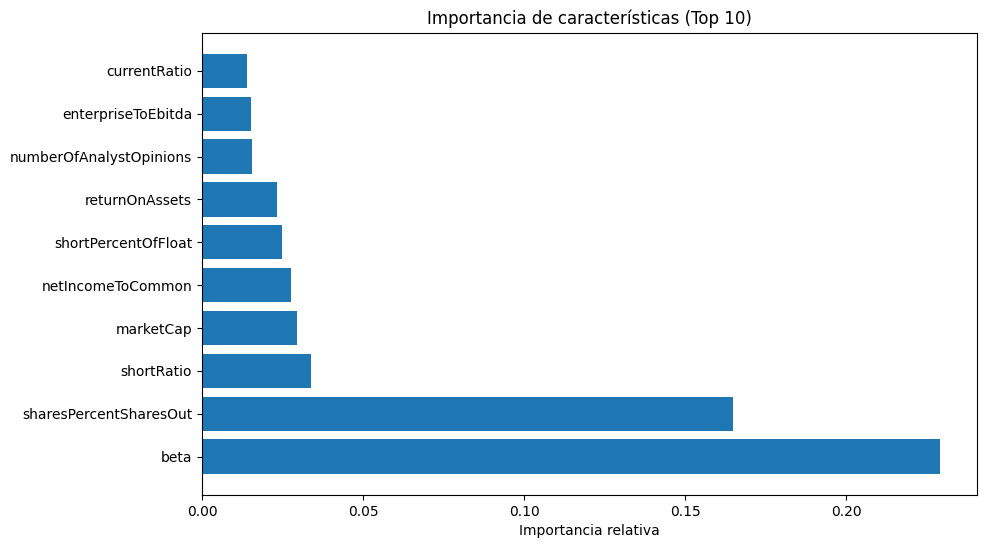

In [29]:
# Definir características (features) y columna objetivo (target)
features = Pen_Merged.drop(columns=['Volatility'])
target = Pen_Merged['Volatility']

# Dividir datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Inicializar RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Configurar búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados por la búsqueda en cuadrícula
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado por la búsqueda en cuadrícula
best_model = grid_search.best_estimator_

# Predecir volatilidad en el conjunto de prueba con el mejor modelo
predictions = best_model.predict(X_test)

# Calcular RMSE del mejor modelo
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"RMSE con mejores hiperparámetros: {rmse}")

# Análisis de importancia de características
feature_importance = best_model.feature_importances_
sorted_indices = feature_importance.argsort()[::-1]
top_features = sorted_indices[:10]  # Las 10 características más importantes

# Gráfico de importancia de características
plt.figure(figsize=(10, 6))
plt.title('Importancia de características (Top 10)')
plt.barh(range(10), feature_importance[top_features], align='center')
plt.yticks(range(10), X_train.columns[top_features])
plt.xlabel('Importancia relativa')
plt.show()

In [30]:
predictions = best_model.predict(X_test)

In [31]:
# Agregar predicciones como columna al conjunto de prueba
X_test_with_predictions = X_test.copy()  # Copia del conjunto de prueba
X_test_with_predictions['Prediccion_Volatilidad'] = predictions  # Agregar columna de predicciones

In [32]:
nuevo_df = X_test_with_predictions[['Prediccion_Volatilidad']].copy()  # Copia la columna de 'X_test_with_predictions'

nuevo_df = nuevo_df.merge(copia_Seg[['Volatility']], left_index=True, right_index=True)

In [33]:
diferencia_df = pd.DataFrame()
diferencia_df['Diferencia_Volatilidad'] = nuevo_df['Volatility'] - nuevo_df['Prediccion_Volatilidad'] 

In [34]:
diferencia_df.describe()

,Diferencia_Volatilidad
count,101.000000
mean,0.000448
std,0.003323
min,-0.006212
25%,-0.001521
50%,-0.000237
75%,0.002198
max,0.010806
